# Directed Sampling 


### initialising logging and notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)
!date
BABELDRAW=False

Do 13. Apr 23:49:26 CEST 2017


### set up graph source

In [2]:
# get data
from eden.io.gspan import gspan_to_eden
from itertools import islice
import graphlearn.utils.draw as draw
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

dataset_fname = '../../toolsdata/bursi.pos.gspan'

### set up a scoring system :D 

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from eden.graph import Vectorizer

class VecComparator():
    def __init__(self, vector):
        self.base = vector 
    def __init__(self,graph, vectorizer):
        self.base = vectorizer.transform([graph])[0]        
    def fit(self,ignore,**ignore2):
        pass
    def predict(self,vector):
        return cosine_similarity(self.base,vector)[0][0]
            
g=get_graphs(dataset_fname)
VC = VecComparator(g.next(),Vectorizer())

### set up a sampler (default parameters shown) with the new scoring system

In [4]:
%%time
'''
TRAINING A SAMPLER
'''
from graphlearn.graphlearn import  Sampler
from eden.graph import Vectorizer
from graphlearn.localsubstitutablegraphgrammar import LocalSubstitutableGraphGrammar
# train a sampler
sampler=Sampler(
                    
                 
                 estimator = VC,
                 grammar=LocalSubstitutableGraphGrammar(radius_list=[0, 1],
                                                        thickness_list=[1,2],
                                                        min_cip_count=2,
                                                        min_interface_count=2), 
                 size_diff_core_filter=-1,
                 core_choice_byfrequency=False,
                 core_choice_byscore=False,
                 core_choice_bytrial=False,
                 core_choice_bytrial_multiplier=1.0,

                 size_constrained_core_choice=-1,
                 similarity=-1,
                 n_samples=None,
                 proposal_probability=False,
                 batch_size=10,
                 n_jobs=0,

                 orig_cip_max_positives=1,
                 orig_cip_min_positives=0,

                 n_steps=50,
                 quick_skip_orig_cip=False,
                 improving_threshold_fraction=-1,
                 improving_linear_start_fraction=0,
                 accept_static_penalty=0.0,
                 accept_min_similarity=0.0,
                 select_cip_max_tries=20,
                 burnin=0,
                 backtrack=0,

                 include_seed=False,
                 keep_duplicates=False,

                 monitor=True
         
               )


# get training graphs
training_graphs = get_graphs(dataset_fname, size=200)
sampler.fit(training_graphs)

# lets look at a few stats about the trained sampler
print('graph grammar stats:')
n_instances, interface_counts, core_counts, cip_counts = sampler.grammar().size()
print('#instances: %d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (n_instances, interface_counts, core_counts, cip_counts))

graph grammar stats:
#instances: 200   #interfaces: 155   #cores: 74   #core-interface-pairs: 627
CPU times: user 3.02 s, sys: 84 ms, total: 3.1 s
Wall time: 5.02 s


# Sample and show generated graphs

In [5]:
%%time
from itertools import islice
graphs = get_graphs(dataset_fname, size=100)
id_start=36
id_end=id_start+12
input_graphs = islice(graphs,id_start,id_end)



graphs = sampler.transform(input_graphs)




CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 34.8 µs


Graph id: 36


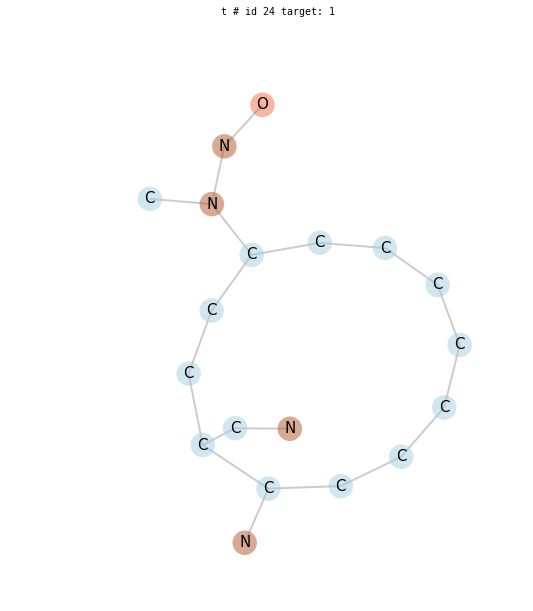

Graph id: 37


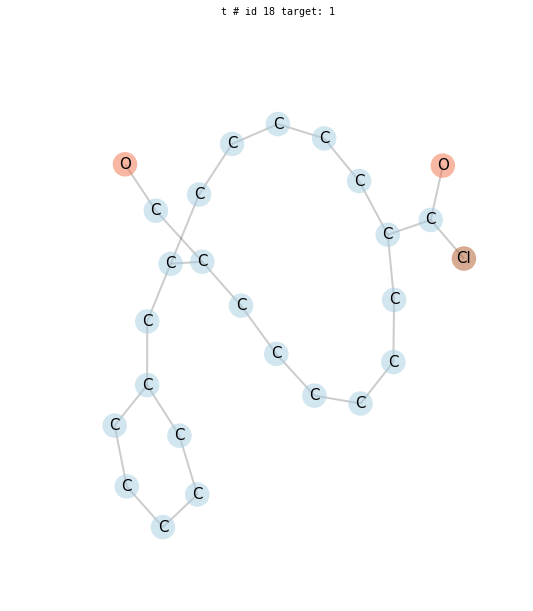

Graph id: 38


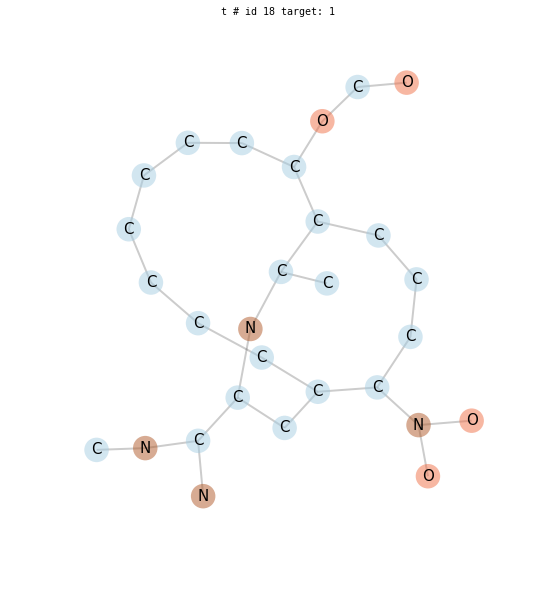

Graph id: 39


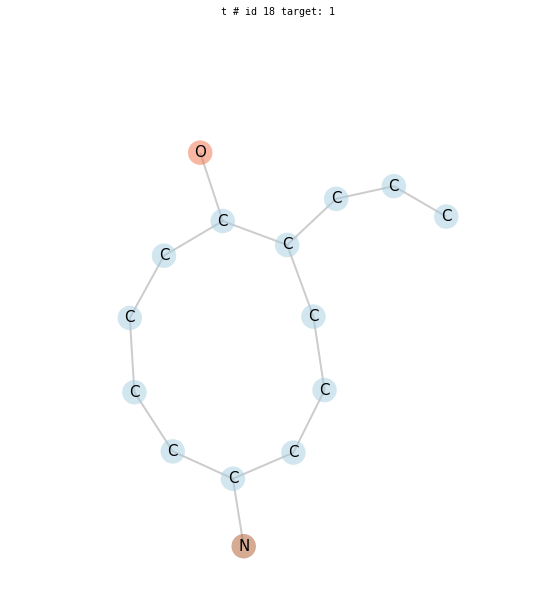

Graph id: 40


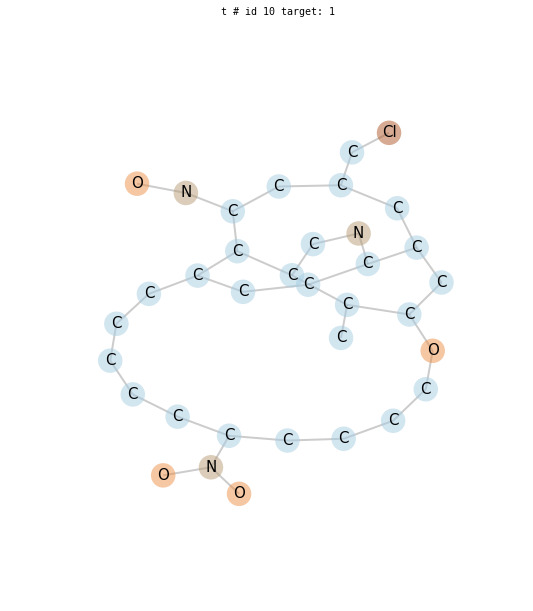

Graph id: 41


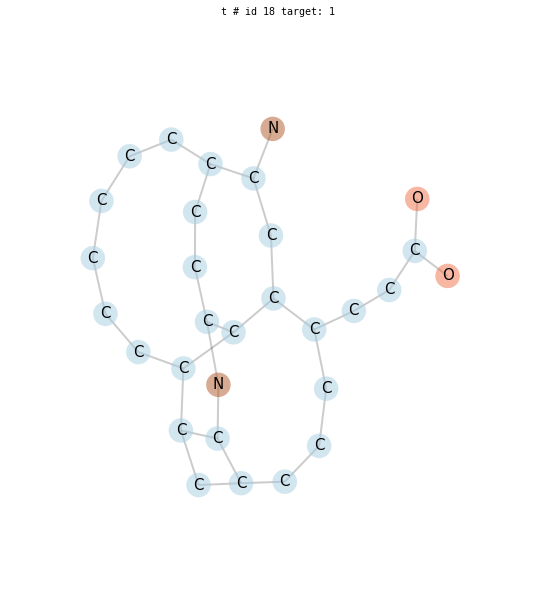

Graph id: 42


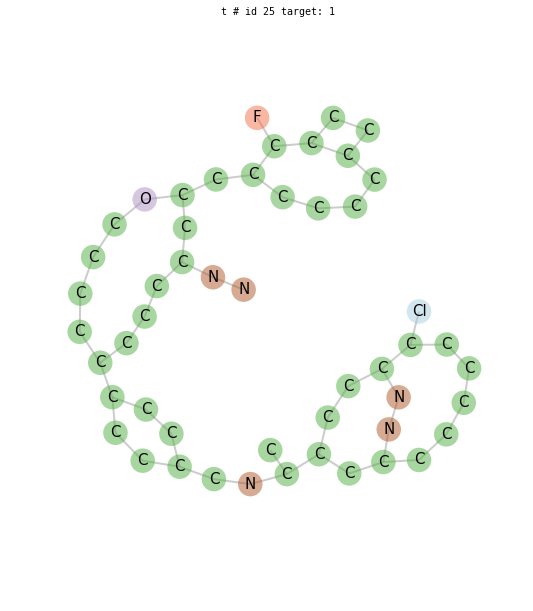

Graph id: 43


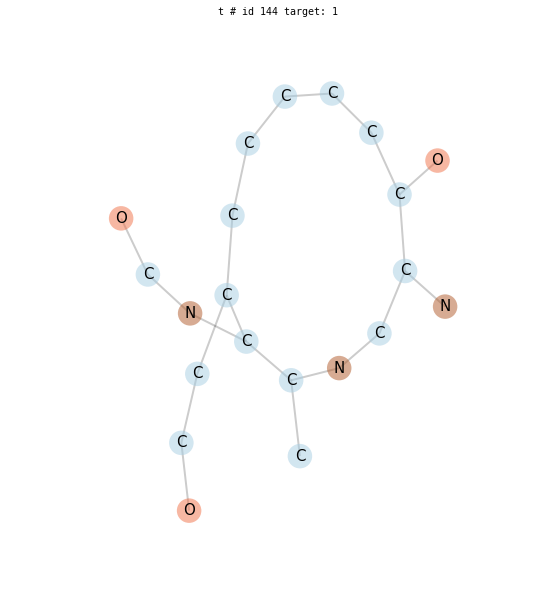

Graph id: 44


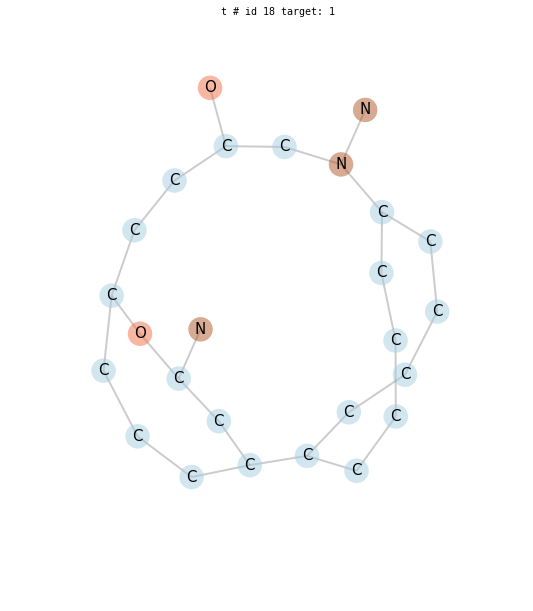

Graph id: 45


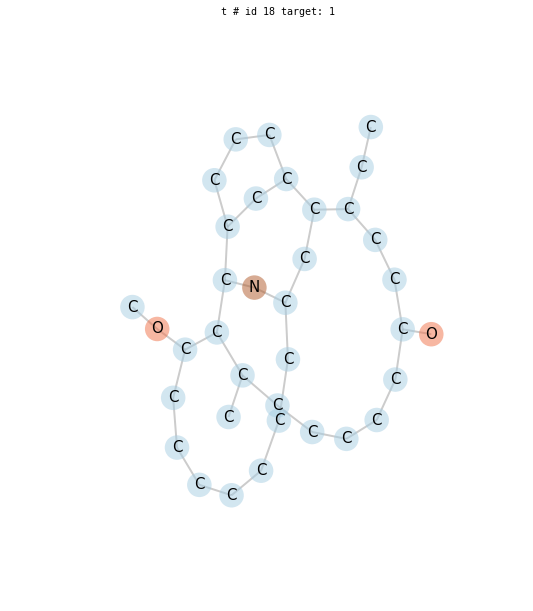

Graph id: 46


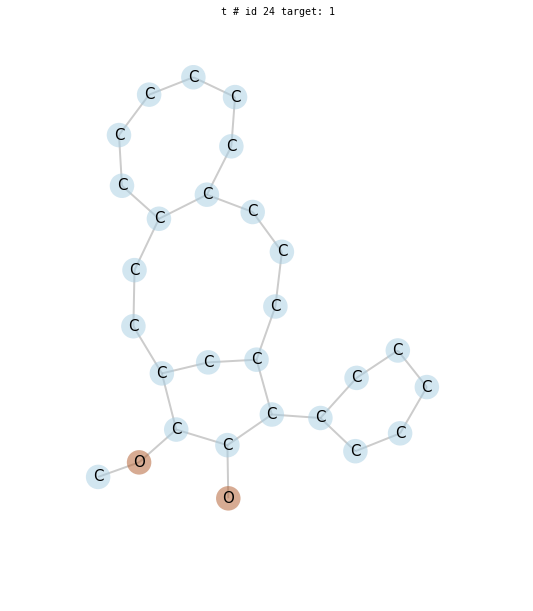

Graph id: 47


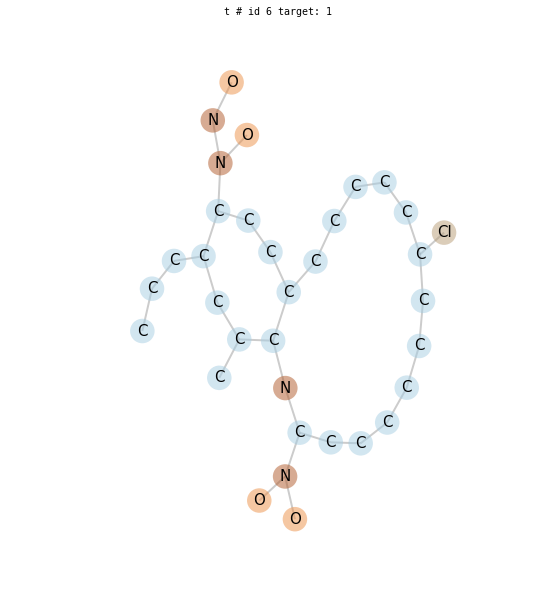

CPU times: user 14.7 s, sys: 5.21 s, total: 19.9 s
Wall time: 14.5 s


In [6]:
%%time
# plot examples of sampling paths

scores=[]
ids=range(id_start,id_end)
for i,graphlist in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(sampler.monitors[i].sampling_info['score_history'])
    if BABELDRAW:
        from graphlearn.utils import openbabel
        openbabel.draw(graphlist, d3=False, n_graphs_per_line=6,size=200)
    else:
        from graphlearn.utils import draw
        draw.graphlearn(graphlist,contract=True,#vertex_label='id',
                   n_graphs_per_line=6, size=10, 
                   colormap='Paired', invert_colormap=False, vertex_color='_labels_',
                   vertex_alpha=0.5, edge_alpha=0.2)
    
 

 

In [7]:
# just looking at a monitor to check if everything is ok :) 
sampler.monitors[1].sampling_info

{'accept_count': 24,
 'notes': '',
 'score_history': [0.34869453671448253,
  0.31588569795802768,
  0.34343077505676484,
  0.42065531443912535,
  0.40707672466221345,
  0.41414544870734049,
  0.41414544870734049,
  0.40707672466221345,
  0.40707672466221345,
  0.40707672466221345,
  0.41116391153806325,
  0.42529156118011335,
  0.42492250267767828,
  0.40921800493992644,
  0.32824085659922586,
  0.32824085659922586,
  0.32824085659922586,
  0.42027991912164381,
  0.3222770562709053,
  0.3222770562709053,
  0.34482218661531694,
  0.34482218661531694,
  0.37044837575826756,
  0.37044837575826756,
  0.37044837575826756,
  0.37044837575826756,
  0.39929005428591269,
  0.47501580101754559,
  0.39929005428591269,
  0.39929005428591269,
  0.45382712042422851,
  0.47677301501776082,
  0.47677301501776082,
  0.47677301501776082,
  0.47677301501776082,
  0.518990610756209,
  0.518990610756209,
  0.52028928424553689,
  0.52028928424553689,
  0.52028928424553689,
  0.52028928424553689,
  0.5202892

# Show sample score history

4


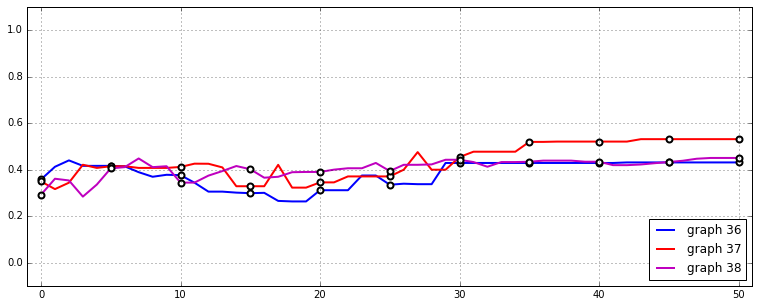

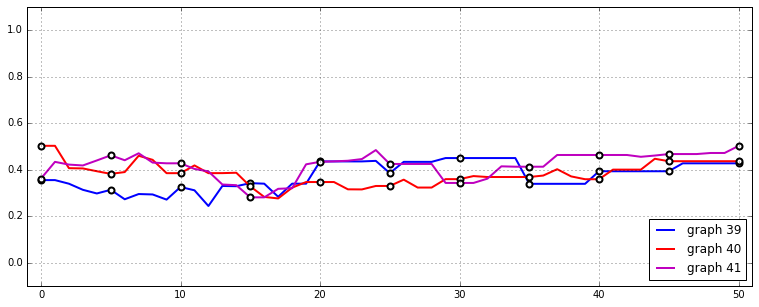

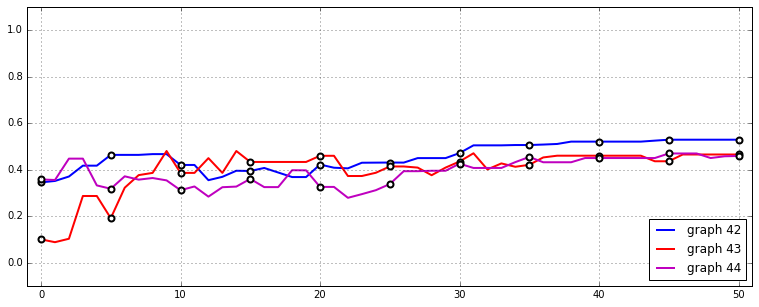

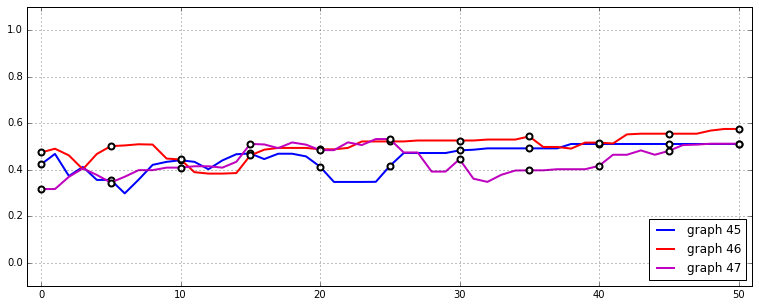

CPU times: user 880 ms, sys: 1.03 s, total: 1.91 s
Wall time: 703 ms


In [14]:
%%time
# plot sampling path score
n_steps=sampler.n_steps
n_samples= sampler.n_samples


from itertools import islice
import numpy as np
import pylab as plt
markevery=  n_steps/(n_samples) if n_samples else 10
step=1
num_graphs_per_plot=3

import math
num_plots= int(math.ceil(len(scores)/float(num_graphs_per_plot)))
print num_plots
for i in range(num_plots):
    plt.figure(figsize=(13,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
     
        data = list(islice(score,None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        plt.plot(data, linestyle='None',markevery=markevery, markerfacecolor='white', marker='o', markeredgewidth=2,markersize=6)
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlim(-1,n_steps+1)
    plt.ylim(-0.1,1.1)
    plt.show()
    

    

---